# Inspector

Inspecting the generated ASTs.

In [98]:
import sys

In [100]:
sys.version

'3.6.6 | packaged by conda-forge | (default, Jul 26 2018, 09:55:02) \n[GCC 4.2.1 Compatible Apple LLVM 6.1.0 (clang-602.0.53)]'

In [101]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn
import json
import os
import joblib
from operator import itemgetter
import networkx as nx
from networkx.readwrite import json_graph
import matplotlib.colors as mcolors
import collections

In [156]:
DATA_PATH = 'data/keras-example/graph/train/'

In [157]:
PREFIX = 'keras'

## Load data

### Features

In [158]:
feats = np.load(DATA_PATH+PREFIX+'-feats.npy')
feats.shape

(101632, 104)

### Classes

In [159]:
class_map = json.load(open(DATA_PATH+PREFIX+"-class_map.json"))

### Graph

In [160]:
G_data = json.load(open(DATA_PATH+PREFIX+ "-G.json"))
G = json_graph.node_link_graph(G_data)
print(G.number_of_nodes(), G.number_of_edges())

101632 317327


### Node id map

In [161]:
node_id_map = json.load(open(DATA_PATH+PREFIX+"-id_map.json"))

### File map

In [162]:
file_map = json.load(open(DATA_PATH+PREFIX+"-file_map.json"))

### Source-code line map

In [163]:
source_map = json.load(open(DATA_PATH+PREFIX+"-source_map.json"))

### Parse map

In [140]:
parse_map = json.load(open(DATA_PATH+PREFIX+"-parse_map.json"))

FileNotFoundError: [Errno 2] No such file or directory: 'data/code-example/graph/0_raw-parse_map.json'

### AST Token maps

In [164]:
#ast_symbol_dict = joblib.load(filename='ast_symbol_dict')
inv_ast_symbol_dict = joblib.load(filename='misc/inv_ast_symbol_dict')

In [165]:
from _ast import *
import sys

MOD_SYMBOLS = [Module, Interactive, Expression, Suite]
STMT_SYMBOLS = [FunctionDef, AsyncFunctionDef, ClassDef, Return, Delete, \
                Assign, AugAssign, For, AsyncFor, While, If, With, AsyncWith, \
                Raise, Try, Assert, Import, ImportFrom, Global, Nonlocal, \
                Expr, Pass, Break, Continue]
EXPR_SYMBOLS = [BoolOp, BinOp, UnaryOp, Lambda, IfExp, Dict, Set, ListComp, \
                SetComp, DictComp, GeneratorExp, Await, Yield, YieldFrom, \
                Compare, Call, Num, Str, FormattedValue, JoinedStr, Bytes, \
                NameConstant, Ellipsis, Constant, Attribute, Subscript, \
                Starred, Name, List, Tuple]
EXPR_CONTENT_SYMBOLS = [Load, Store, Del, AugLoad, AugStore, Param]
SLICE_SYMBOLS = [Slice, ExtSlice, Index]
BOOLOP_SYMBOLS = [And, Or]
OPERATOR_SYMBOLS = [Add, Sub, Mult, MatMult, Div, Mod, Pow, LShift, RShift, \
                    BitOr, BitXor, BitAnd, FloorDiv]
UNARYOP_SYMBOLS = [Invert, Not, UAdd, USub]
CMPOP_SYMBOLS = [Eq, NotEq, Lt, LtE, Gt, GtE, Is, IsNot, In, NotIn]
COMPREHENSION_SYMBOLS = [comprehension]
EXCEPT_SYMBOLS = [excepthandler, ExceptHandler]
ARG_SYMBOLS = [arguments, arg, keyword]
IMPORT_SYMBOLS = [alias, withitem]
PYTHON_SYMBOLS = MOD_SYMBOLS + STMT_SYMBOLS + EXPR_SYMBOLS \
               + EXPR_CONTENT_SYMBOLS + SLICE_SYMBOLS \
               + BOOLOP_SYMBOLS + OPERATOR_SYMBOLS \
               + UNARYOP_SYMBOLS + CMPOP_SYMBOLS \
               + EXCEPT_SYMBOLS + ARG_SYMBOLS + IMPORT_SYMBOLS \
               + COMPREHENSION_SYMBOLS
AST_SYMBOL_DICT = dict((v, k) for (k, v) in enumerate(PYTHON_SYMBOLS))

In [166]:
AST_SYMBOL_DICT

{_ast.Module: 0,
 _ast.Interactive: 1,
 _ast.Expression: 2,
 _ast.Suite: 3,
 _ast.FunctionDef: 4,
 _ast.AsyncFunctionDef: 5,
 _ast.ClassDef: 6,
 _ast.Return: 7,
 _ast.Delete: 8,
 _ast.Assign: 9,
 _ast.AugAssign: 10,
 _ast.For: 11,
 _ast.AsyncFor: 12,
 _ast.While: 13,
 _ast.If: 14,
 _ast.With: 15,
 _ast.AsyncWith: 16,
 _ast.Raise: 17,
 _ast.Try: 18,
 _ast.Assert: 19,
 _ast.Import: 20,
 _ast.ImportFrom: 21,
 _ast.Global: 22,
 _ast.Nonlocal: 23,
 _ast.Expr: 24,
 _ast.Pass: 25,
 _ast.Break: 26,
 _ast.Continue: 27,
 _ast.BoolOp: 28,
 _ast.BinOp: 29,
 _ast.UnaryOp: 30,
 _ast.Lambda: 31,
 _ast.IfExp: 32,
 _ast.Dict: 33,
 _ast.Set: 34,
 _ast.ListComp: 35,
 _ast.SetComp: 36,
 _ast.DictComp: 37,
 _ast.GeneratorExp: 38,
 _ast.Await: 39,
 _ast.Yield: 40,
 _ast.YieldFrom: 41,
 _ast.Compare: 42,
 _ast.Call: 43,
 _ast.Num: 44,
 _ast.Str: 45,
 _ast.FormattedValue: 46,
 _ast.JoinedStr: 47,
 _ast.Bytes: 48,
 _ast.NameConstant: 49,
 _ast.Ellipsis: 50,
 _ast.Constant: 51,
 _ast.Attribute: 52,
 _ast.Subscr

---

## Helpers

In [167]:
def get_name_from_token(token, show_id=True):
    tokenid  = np.nonzero(token)[0][0]
    return get_name_from_token_id(tokenid, show_id=show_id)

In [168]:
def get_name_from_token_id(tokenid, show_id = True):
    strtoken = inv_ast_symbol_dict.get(tokenid)
    
    if strtoken is None:
        if tokenid == 104:
            strtoken = "Root Node"
        else:
            strtoken = "<Unknown token>"
    else:
        strtoken = strtoken.__name__
        
    if show_id is True:
        strtoken += " " + str(tokenid) 
        
    return strtoken

In [169]:
def inspect_node_recursive(node_id, G, feats, depth=0):
    '''
    Recursively print neighbouring node tokens
    '''
    neighbours = list(G.adj[node_id])
    for n in neighbours:
        strtoken = get_name_from_token(feats[n])
        if strtoken=="Root Node 104":
            print(n)
        print(" "*depth, strtoken)
        if depth < 2:
            inspect_node_recursive(n, G, feats, depth+1)

In [170]:
# Example usage
inspect_node_recursive(0, G=G, feats=feats)

 Expr 24
  Module 0
   Expr 24
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   Import 20
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   FunctionDef 4
   FunctionDef 4
   FunctionDef 4
   FunctionDef 4
   FunctionDef 4
   Assign 9
   Assign 9
   Assign 9
   Assign 9
   Assign 9
   FunctionDef 4
   FunctionDef 4
   FunctionDef 4
   Module 0
  ImportFrom 21
   Module 0
   Expr 24
   ImportFrom 21
   ImportFrom 21
   Import 20
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   FunctionDef 4
   FunctionDef 4
   FunctionDef 4
   FunctionDef 4

   FunctionDef 4
   FunctionDef 4
   Assign 9
   Assign 9
   Assign 9
   Assign 9
   FunctionDef 4
   FunctionDef 4
   FunctionDef 4
   Name 55
   Name 55
   Name 55
  Assign 9
   Module 0
   Expr 24
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   Import 20
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   FunctionDef 4
   FunctionDef 4
   FunctionDef 4
   FunctionDef 4
   FunctionDef 4
   Assign 9
   Assign 9
   Assign 9
   Assign 9
   FunctionDef 4
   FunctionDef 4
   FunctionDef 4
   Name 55
   Name 55
   Name 55
  Assign 9
   Module 0
   Expr 24
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   Import 20
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom

   ImportFrom 21
   Import 20
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   FunctionDef 4
   FunctionDef 4
   FunctionDef 4
   FunctionDef 4
   FunctionDef 4
   Assign 9
   Assign 9
   Assign 9
   Assign 9
   Assign 9
   FunctionDef 4
   FunctionDef 4
   FunctionDef 4
   alias 101
  ImportFrom 21
   Module 0
   Expr 24
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   Import 20
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   FunctionDef 4
   FunctionDef 4
   FunctionDef 4
   FunctionDef 4
   FunctionDef 4
   Assign 9
   Assign 9
   Assign 9
   Assign 9
   Assign 9
   

   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   FunctionDef 4
   FunctionDef 4
   FunctionDef 4
   FunctionDef 4
   FunctionDef 4
   Assign 9
   Assign 9
   Assign 9
   Assign 9
   Assign 9
   FunctionDef 4
   FunctionDef 4
   FunctionDef 4
   alias 101
  ImportFrom 21
   Module 0
   Expr 24
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   Import 20
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   FunctionDef 4
   FunctionDef 4
   FunctionDef 4
   FunctionDef 4
   FunctionDef 4
   Assign 9
   Assign 9
   Assign 9
   Assign 9
   Assign 9
   FunctionDef 4

   Name 55
  Assign 9
   Module 0
   Expr 24
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   Import 20
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   FunctionDef 4
   FunctionDef 4
   FunctionDef 4
   FunctionDef 4
   FunctionDef 4
   Assign 9
   Assign 9
   Assign 9
   Assign 9
   FunctionDef 4
   FunctionDef 4
   FunctionDef 4
   Name 55
   Name 55
   Name 55
  Assign 9
   Module 0
   Expr 24
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   Import 20
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   FunctionDef 4
   FunctionDef 

   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   FunctionDef 4
   FunctionDef 4
   FunctionDef 4
   FunctionDef 4
   FunctionDef 4
   Assign 9
   Assign 9
   Assign 9
   Assign 9
   Assign 9
   FunctionDef 4
   FunctionDef 4
   FunctionDef 4
   alias 101
  FunctionDef 4
   Module 0
   Expr 24
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   Import 20
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   FunctionDef 4
   FunctionDef 4
   FunctionDef 4
   FunctionDef 4
   Assign 9
   Assign 9
   Assign 9
   Assign 9
   Assign 9
   FunctionDef 4
   FunctionDef 4
   FunctionDef 4
   arguments 98
   Return 7
  FunctionDef 4
   Module 0
   Expr 24
   ImportFrom 21
   ImportFrom 21


   FunctionDef 4
   FunctionDef 4
   FunctionDef 4
   FunctionDef 4
   FunctionDef 4
   Assign 9
   Assign 9
   Assign 9
   Assign 9
   Assign 9
   FunctionDef 4
   FunctionDef 4
   FunctionDef 4
   alias 101
  ImportFrom 21
   Module 0
   Expr 24
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   Import 20
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   FunctionDef 4
   FunctionDef 4
   FunctionDef 4
   FunctionDef 4
   FunctionDef 4
   Assign 9
   Assign 9
   Assign 9
   Assign 9
   Assign 9
   FunctionDef 4
   FunctionDef 4
   FunctionDef 4
   alias 101
  ImportFrom 21
   Module 0
   Expr 24
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   Import 20
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
  

   Assign 9
   Assign 9
   FunctionDef 4
   FunctionDef 4
   FunctionDef 4
   alias 101
  ImportFrom 21
   Module 0
   Expr 24
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   Import 20
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   FunctionDef 4
   FunctionDef 4
   FunctionDef 4
   FunctionDef 4
   FunctionDef 4
   Assign 9
   Assign 9
   Assign 9
   Assign 9
   Assign 9
   FunctionDef 4
   FunctionDef 4
   FunctionDef 4
   alias 101
  ImportFrom 21
   Module 0
   Expr 24
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   Import 20
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   I

   Expr 24
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   Import 20
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   FunctionDef 4
   FunctionDef 4
   FunctionDef 4
   FunctionDef 4
   FunctionDef 4
   Assign 9
   Assign 9
   Assign 9
   Assign 9
   Assign 9
   FunctionDef 4
   FunctionDef 4
   FunctionDef 4
   Module 0
  Expr 24
   Module 0
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   Import 20
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   FunctionDef 4
   FunctionDef 4
   FunctionDef 4
   FunctionDef 4
   FunctionDef 4
  

   ImportFrom 21
   FunctionDef 4
   FunctionDef 4
   FunctionDef 4
   FunctionDef 4
   FunctionDef 4
   Assign 9
   Assign 9
   Assign 9
   Assign 9
   FunctionDef 4
   FunctionDef 4
   FunctionDef 4
   Name 55
   Name 55
   Name 55
  Assign 9
   Module 0
   Expr 24
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   Import 20
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   FunctionDef 4
   FunctionDef 4
   FunctionDef 4
   FunctionDef 4
   FunctionDef 4
   Assign 9
   Assign 9
   Assign 9
   Assign 9
   FunctionDef 4
   FunctionDef 4
   FunctionDef 4
   Name 55
   Name 55
   Name 55
  Assign 9
   Module 0
   Expr 24
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   Import 20
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom

   Module 0
   Expr 24
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   Import 20
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   FunctionDef 4
   FunctionDef 4
   FunctionDef 4
   FunctionDef 4
   Assign 9
   Assign 9
   Assign 9
   Assign 9
   Assign 9
   FunctionDef 4
   FunctionDef 4
   FunctionDef 4
   arguments 98
   Return 7
  FunctionDef 4
   Module 0
   Expr 24
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   Import 20
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   FunctionDef 4
   FunctionDef 4
   FunctionDef 4
   Funct

   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   FunctionDef 4
   FunctionDef 4
   FunctionDef 4
   FunctionDef 4
   FunctionDef 4
   Assign 9
   Assign 9
   Assign 9
   Assign 9
   Assign 9
   FunctionDef 4
   FunctionDef 4
   FunctionDef 4
   alias 101
  ImportFrom 21
   Module 0
   Expr 24
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   Import 20
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   FunctionDef 4
   FunctionDef 4
   FunctionDef 4
   FunctionDef 4
   FunctionDef 4
   Assign 9
   Assign 9
   Assign 9
   Assign 9
   Assign 9
   FunctionDef 4
   FunctionDef 4
   FunctionDef 4
   alias 101
  I

   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   FunctionDef 4
   FunctionDef 4
   FunctionDef 4
   FunctionDef 4
   FunctionDef 4
   Assign 9
   Assign 9
   Assign 9
   Assign 9
   Assign 9
   FunctionDef 4
   FunctionDef 4
   FunctionDef 4
   alias 101
  ImportFrom 21
   Module 0
   Expr 24
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   Import 20
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   FunctionDef 4
   FunctionDef 4
   FunctionDef 4
   FunctionDef 4
   FunctionDef 4
   Assign 9
   Assign 9
   Assign 9
   Assign 9
   Assign 9
   FunctionDef 4
   FunctionDef 4
   FunctionDef 4
   alias 101
  ImportFrom 21
   Module 0
   Expr 24
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   Import 20
   ImportFrom 21
  

   FunctionDef 4
   FunctionDef 4
   FunctionDef 4
   Assign 9
   Assign 9
   Assign 9
   Assign 9
   Assign 9
   FunctionDef 4
   FunctionDef 4
   FunctionDef 4
   Module 0
  Expr 24
   Module 0
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   Import 20
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   FunctionDef 4
   FunctionDef 4
   FunctionDef 4
   FunctionDef 4
   FunctionDef 4
   Assign 9
   Assign 9
   Assign 9
   Assign 9
   Assign 9
   FunctionDef 4
   FunctionDef 4
   FunctionDef 4
   Str 45
  ImportFrom 21
   Module 0
   Expr 24
   ImportFrom 21
   ImportFrom 21
   Import 20
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   Imp

   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   FunctionDef 4
   FunctionDef 4
   FunctionDef 4
   FunctionDef 4
   FunctionDef 4
   Assign 9
   Assign 9
   Assign 9
   Assign 9
   FunctionDef 4
   FunctionDef 4
   FunctionDef 4
   Name 55
   Name 55
   Name 55
  Assign 9
   Module 0
   Expr 24
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   Import 20
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   FunctionDef 4
   FunctionDef 4
   FunctionDef 4
   FunctionDef 4
   FunctionDef 4
   Assign 9
   Assign 9
   Assign 9
   Assign 9
   Funct

   FunctionDef 4
   FunctionDef 4
   FunctionDef 4
   Assign 9
   Assign 9
   Assign 9
   Assign 9
   Assign 9
   FunctionDef 4
   FunctionDef 4
   FunctionDef 4
   arguments 98
   Return 7
  FunctionDef 4
   Module 0
   Expr 24
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   Import 20
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   FunctionDef 4
   FunctionDef 4
   FunctionDef 4
   FunctionDef 4
   Assign 9
   Assign 9
   Assign 9
   Assign 9
   Assign 9
   FunctionDef 4
   FunctionDef 4
   FunctionDef 4
   arguments 98
   Return 7
  FunctionDef 4
   Module 0
   Expr 24
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   Import 20
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   Imp

   Assign 9
   FunctionDef 4
   FunctionDef 4
   FunctionDef 4
   alias 101
  ImportFrom 21
   Module 0
   Expr 24
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   Import 20
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   FunctionDef 4
   FunctionDef 4
   FunctionDef 4
   FunctionDef 4
   FunctionDef 4
   Assign 9
   Assign 9
   Assign 9
   Assign 9
   Assign 9
   FunctionDef 4
   FunctionDef 4
   FunctionDef 4
   alias 101
  ImportFrom 21
   Module 0
   Expr 24
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   Import 20
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21

   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   Import 20
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   FunctionDef 4
   FunctionDef 4
   FunctionDef 4
   FunctionDef 4
   FunctionDef 4
   Assign 9
   Assign 9
   Assign 9
   Assign 9
   Assign 9
   FunctionDef 4
   FunctionDef 4
   FunctionDef 4
   alias 101
  ImportFrom 21
   Module 0
   Expr 24
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   Import 20
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   FunctionDef 4
   FunctionDef 4
   FunctionDef 4
   FunctionDef 4
   FunctionDef 4
   Assign 9
   Assign 9
   As

   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   FunctionDef 4
   FunctionDef 4
   FunctionDef 4
   FunctionDef 4
   FunctionDef 4
   Assign 9
   Assign 9
   Assign 9
   Assign 9
   Assign 9
   FunctionDef 4
   FunctionDef 4
   FunctionDef 4
   Str 45
  ImportFrom 21
   Module 0
   Expr 24
   ImportFrom 21
   ImportFrom 21
   Import 20
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   FunctionDef 4
   FunctionDef 4
   FunctionDef 4
   FunctionDef 4
   FunctionDef 4
   Assign 9
   Assign 9
   Assign 9
   Assign 9
   Assign 9
   FunctionDef 4
   FunctionDef 4
   FunctionDef 4
   alias 101
  ImportFrom 21
   Module 0
   Expr 24
 

   Assign 9
   Assign 9
   FunctionDef 4
   FunctionDef 4
   FunctionDef 4
   Name 55
   Name 55
   Name 55
  Assign 9
   Module 0
   Expr 24
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   Import 20
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   FunctionDef 4
   FunctionDef 4
   FunctionDef 4
   FunctionDef 4
   FunctionDef 4
   Assign 9
   Assign 9
   Assign 9
   Assign 9
   FunctionDef 4
   FunctionDef 4
   FunctionDef 4
   Name 55
   Name 55
   Name 55
  Assign 9
   Module 0
   Expr 24
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   Import 20
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   

   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   FunctionDef 4
   FunctionDef 4
   FunctionDef 4
   FunctionDef 4
   Assign 9
   Assign 9
   Assign 9
   Assign 9
   Assign 9
   FunctionDef 4
   FunctionDef 4
   FunctionDef 4
   arguments 98
   Return 7
  FunctionDef 4
   Module 0
   Expr 24
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   Import 20
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   FunctionDef 4
   FunctionDef 4
   FunctionDef 4
   FunctionDef 4
   Assign 9
   Assign 9
   Assign 9
   Assign 9
   Assign 9
   FunctionDef 4
   FunctionDef 4
   FunctionDef 4
 

   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   FunctionDef 4
   FunctionDef 4
   FunctionDef 4
   FunctionDef 4
   FunctionDef 4
   Assign 9
   Assign 9
   Assign 9
   Assign 9
   Assign 9
   FunctionDef 4
   FunctionDef 4
   FunctionDef 4
   alias 101
  ImportFrom 21
   Module 0
   Expr 24
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   Import 20
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   FunctionDef 4
   FunctionDef 4
   FunctionDef 4
   FunctionDef 4
   FunctionDef 4
   Assign 9
   Assign 9
   Assign 9
   Assign 9
   Assign 9
   FunctionDef 4
   FunctionDef 4
   FunctionDef 4
   alias 101
  ImportFrom 21
   Module 0
   Expr 24
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   Import 20
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
  

   ImportFrom 21
   Import 20
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   FunctionDef 4
   FunctionDef 4
   FunctionDef 4
   FunctionDef 4
   FunctionDef 4
   Assign 9
   Assign 9
   Assign 9
   Assign 9
   Assign 9
   FunctionDef 4
   FunctionDef 4
   FunctionDef 4
   alias 101
  ImportFrom 21
   Module 0
   Expr 24
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   Import 20
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   FunctionDef 4
   FunctionDef 4
   FunctionDef 4
   FunctionDef 4
   FunctionDef 4
   Assign 9
   Assign 9
   Assign 9
   Assign 9
   Assign 9
   

   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   FunctionDef 4
   FunctionDef 4
   FunctionDef 4
   FunctionDef 4
   FunctionDef 4
   Assign 9
   Assign 9
   Assign 9
   Assign 9
   FunctionDef 4
   FunctionDef 4
   FunctionDef 4
   Name 55
   Name 55
   Name 55
  Assign 9
   Module 0
   Expr 24
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   Import 20
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   FunctionDef 4
   FunctionDef 4
   FunctionDef 4
   FunctionDef 4
   FunctionDef 4
   Assign 9
   Assign 9
   Assign 9
   Assign 9
   FunctionDef 4
   FunctionDef 4
   Funct

   FunctionDef 4
   Assign 9
   Assign 9
   Assign 9
   Assign 9
   Assign 9
   FunctionDef 4
   FunctionDef 4
   FunctionDef 4
   arguments 98
   Return 7
  FunctionDef 4
   Module 0
   Expr 24
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   Import 20
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   FunctionDef 4
   FunctionDef 4
   FunctionDef 4
   FunctionDef 4
   Assign 9
   Assign 9
   Assign 9
   Assign 9
   Assign 9
   FunctionDef 4
   FunctionDef 4
   FunctionDef 4
   arguments 98
   Return 7
  FunctionDef 4
   Module 0
   Expr 24
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   Import 20
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   Imp

   alias 101
  ImportFrom 21
   Module 0
   Expr 24
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   Import 20
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   FunctionDef 4
   FunctionDef 4
   FunctionDef 4
   FunctionDef 4
   FunctionDef 4
   Assign 9
   Assign 9
   Assign 9
   Assign 9
   Assign 9
   FunctionDef 4
   FunctionDef 4
   FunctionDef 4
   alias 101
  ImportFrom 21
   Module 0
   Expr 24
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   Import 20
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   FunctionDef 4
   FunctionDef 4
   FunctionDef 4
   Function

   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   FunctionDef 4
   FunctionDef 4
   FunctionDef 4
   FunctionDef 4
   FunctionDef 4
   Assign 9
   Assign 9
   Assign 9
   Assign 9
   Assign 9
   FunctionDef 4
   FunctionDef 4
   FunctionDef 4
   alias 101
  ImportFrom 21
   Module 0
   Expr 24
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   Import 20
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   FunctionDef 4
   FunctionDef 4
   FunctionDef 4
   FunctionDef 4
   FunctionDef 4
   Assign 9
   Assign 9
   Assign 9
   Assign 9
   Assign 9
   FunctionDef 4
   FunctionDef 4

   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   FunctionDef 4
   FunctionDef 4
   FunctionDef 4
   FunctionDef 4
   FunctionDef 4
   Assign 9
   Assign 9
   Assign 9
   Assign 9
   Assign 9
   FunctionDef 4
   FunctionDef 4
   FunctionDef 4
   alias 101
  ImportFrom 21
   Module 0
   Expr 24
   ImportFrom 21
   ImportFrom 21
   Import 20
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   FunctionDef 4
   FunctionDef 4
   FunctionDef 4
   FunctionDef 4
   FunctionDef 4
   Assign 9
   Assign 9
   Assign 9
   Assign 9
   Assign 9
   FunctionDef 4
   FunctionDef 4
   FunctionDef 4
   alias 101
  ImportFrom 21
   Module 0
   Expr 24
   ImportFrom 21
   ImportFrom 21
   Import 20
   ImportFrom 21
  

   ImportFrom 21
   ImportFrom 21
   FunctionDef 4
   FunctionDef 4
   FunctionDef 4
   FunctionDef 4
   FunctionDef 4
   Assign 9
   Assign 9
   Assign 9
   Assign 9
   FunctionDef 4
   FunctionDef 4
   FunctionDef 4
   Name 55
   Name 55
   Name 55
  Assign 9
   Module 0
   Expr 24
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   Import 20
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   FunctionDef 4
   FunctionDef 4
   FunctionDef 4
   FunctionDef 4
   FunctionDef 4
   Assign 9
   Assign 9
   Assign 9
   Assign 9
   FunctionDef 4
   FunctionDef 4
   FunctionDef 4
   Name 55
   Name 55
   Name 55
  Assign 9
   Module 0
   Expr 24
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   Import 20
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom

   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   FunctionDef 4
   FunctionDef 4
   FunctionDef 4
   FunctionDef 4
   FunctionDef 4
   Assign 9
   Assign 9
   Assign 9
   Assign 9
   Assign 9
   FunctionDef 4
   FunctionDef 4
   FunctionDef 4
   alias 101
  ImportFrom 21
   Module 0
   Expr 24
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   Import 20
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   FunctionDef 4
   FunctionDef 4
   FunctionDef 4
   FunctionDef 4
   FunctionDef 4
   Assign 9
   Assign 9
   Assign 9
   Assign 9
   Assign 9
   FunctionDef 4
   FunctionDef 4
   FunctionDef 4
   alias 101
  ImportFrom 21
   M

   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   FunctionDef 4
   FunctionDef 4
   FunctionDef 4
   FunctionDef 4
   FunctionDef 4
   Assign 9
   Assign 9
   Assign 9
   Assign 9
   Assign 9
   FunctionDef 4
   FunctionDef 4
   FunctionDef 4
   alias 101
  ImportFrom 21
   Module 0
   Expr 24
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   Import 20
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   FunctionDef 4
   FunctionDef 4
   FunctionDef 4
   FunctionDef 4
   FunctionDef 4
   Assign 9
   Assign 9
   Assign 9
   Assign 9
   Assign 9
   FunctionDef 4
   FunctionDef 4
   FunctionDef 4
   alias 101
  ImportFrom 21
   Module 0
   Expr 24
   ImportFrom 2

   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   FunctionDef 4
   FunctionDef 4
   FunctionDef 4
   FunctionDef 4
   FunctionDef 4
   Assign 9
   Assign 9
   Assign 9
   Assign 9
   Assign 9
   FunctionDef 4
   FunctionDef 4
   FunctionDef 4
   alias 101
  ImportFrom 21
   Module 0
   Expr 24
   ImportFrom 21
   ImportFrom 21
   Import 20
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   FunctionDef 4
   FunctionDef 4
   FunctionDef 4
   FunctionDef 4
   FunctionDef 4
   Assign 9
   Assign 9
   Assign 9
   Assign 9
   Assign 9
   FunctionDef 4
   FunctionDef 4
   FunctionDef 4
   alias 101
  ImportFrom 21
   Module 0
   Expr 24
   ImportFrom 21
   ImportFrom 21
   Import 20
  

   Assign 9
   FunctionDef 4
   FunctionDef 4
   FunctionDef 4
   Name 55
   Name 55
   Name 55
  Assign 9
   Module 0
   Expr 24
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   Import 20
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   FunctionDef 4
   FunctionDef 4
   FunctionDef 4
   FunctionDef 4
   FunctionDef 4
   Assign 9
   Assign 9
   Assign 9
   Assign 9
   FunctionDef 4
   FunctionDef 4
   FunctionDef 4
   Name 55
   Name 55
  FunctionDef 4
   Module 0
   Expr 24
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   Import 20
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   I

   ImportFrom 21
   ImportFrom 21
   Import 20
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   FunctionDef 4
   FunctionDef 4
   FunctionDef 4
   FunctionDef 4
   Assign 9
   Assign 9
   Assign 9
   Assign 9
   Assign 9
   FunctionDef 4
   FunctionDef 4
   FunctionDef 4
   arguments 98
   Return 7
  FunctionDef 4
   Module 0
   Expr 24
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   Import 20
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   FunctionDef 4
   FunctionDef 4
   FunctionDef 4
   FunctionDef 4
   Assign 9
   Assign 9
   Assi

   ImportFrom 21
   Import 20
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   FunctionDef 4
   FunctionDef 4
   FunctionDef 4
   FunctionDef 4
   FunctionDef 4
   Assign 9
   Assign 9
   Assign 9
   Assign 9
   Assign 9
   FunctionDef 4
   FunctionDef 4
   FunctionDef 4
   alias 101
  ImportFrom 21
   Module 0
   Expr 24
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   Import 20
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   FunctionDef 4
   FunctionDef 4
   FunctionDef 4
   FunctionDef 4
   FunctionDef 4
   Assign 9
   Assign 9
   Assign 9
   Assign 9
   Assign 9
   

   ImportFrom 21
   Import 20
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   FunctionDef 4
   FunctionDef 4
   FunctionDef 4
   FunctionDef 4
   FunctionDef 4
   Assign 9
   Assign 9
   Assign 9
   Assign 9
   Assign 9
   FunctionDef 4
   FunctionDef 4
   FunctionDef 4
   alias 101
  ImportFrom 21
   Module 0
   Expr 24
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   Import 20
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   FunctionDef 4
   FunctionDef 4
   FunctionDef 4
   FunctionDef 4
   FunctionDef 4
   Assign 9
   Assign 9
   Assign 9
   Assign 9
   Assign 9
   

   ImportFrom 21
   Import 20
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   FunctionDef 4
   FunctionDef 4
   FunctionDef 4
   FunctionDef 4
   FunctionDef 4
   Assign 9
   Assign 9
   Assign 9
   Assign 9
   Assign 9
   FunctionDef 4
   FunctionDef 4
   FunctionDef 4
   alias 101
  ImportFrom 21
   Module 0
   Expr 24
   ImportFrom 21
   ImportFrom 21
   Import 20
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   FunctionDef 4
   FunctionDef 4
   FunctionDef 4
   FunctionDef 4
   FunctionDef 4
   Assign 9
   Assign 9
   Assign 9
   Assign 

   FunctionDef 4
   FunctionDef 4
   FunctionDef 4
   FunctionDef 4
   FunctionDef 4
   Assign 9
   Assign 9
   Assign 9
   Assign 9
   FunctionDef 4
   FunctionDef 4
   FunctionDef 4
   Name 55
   Name 55
   Name 55
  Assign 9
   Module 0
   Expr 24
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   Import 20
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   FunctionDef 4
   FunctionDef 4
   FunctionDef 4
   FunctionDef 4
   FunctionDef 4
   Assign 9
   Assign 9
   Assign 9
   Assign 9
   FunctionDef 4
   FunctionDef 4
   FunctionDef 4
   Name 55
   Name 55
  FunctionDef 4
   Module 0
   Expr 24
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   Import 20
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
  

   FunctionDef 4
   FunctionDef 4
   FunctionDef 4
   arguments 98
   Return 7
  FunctionDef 4
   Module 0
   Expr 24
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   Import 20
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   FunctionDef 4
   FunctionDef 4
   FunctionDef 4
   FunctionDef 4
   Assign 9
   Assign 9
   Assign 9
   Assign 9
   Assign 9
   FunctionDef 4
   FunctionDef 4
   FunctionDef 4
   arguments 98
   Return 7
  FunctionDef 4
   Module 0
   Expr 24
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   Import 20
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 2

   alias 101
  ImportFrom 21
   Module 0
   Expr 24
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   Import 20
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   FunctionDef 4
   FunctionDef 4
   FunctionDef 4
   FunctionDef 4
   FunctionDef 4
   Assign 9
   Assign 9
   Assign 9
   Assign 9
   Assign 9
   FunctionDef 4
   FunctionDef 4
   FunctionDef 4
   alias 101
  ImportFrom 21
   Module 0
   Expr 24
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   Import 20
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   FunctionDef 4
   FunctionDef 4
   FunctionDef 4
   Function

   Expr 24
   ImportFrom 21
   ImportFrom 21
   Import 20
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   FunctionDef 4
   FunctionDef 4
   FunctionDef 4
   FunctionDef 4
   FunctionDef 4
   Assign 9
   Assign 9
   Assign 9
   Assign 9
   Assign 9
   FunctionDef 4
   FunctionDef 4
   FunctionDef 4
   alias 101
  ImportFrom 21
   Module 0
   Expr 24
   ImportFrom 21
   ImportFrom 21
   Import 20
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   FunctionDef 4
   FunctionDef 4
   FunctionDef 4
   FunctionDef 4
   FunctionDef 4
   Assign 9
   Ass

   ImportFrom 21
   ImportFrom 21
   FunctionDef 4
   FunctionDef 4
   FunctionDef 4
   FunctionDef 4
   FunctionDef 4
   Assign 9
   Assign 9
   Assign 9
   Assign 9
   FunctionDef 4
   FunctionDef 4
   FunctionDef 4
   Name 55
   Name 55
   Name 55
  Assign 9
   Module 0
   Expr 24
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   Import 20
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   FunctionDef 4
   FunctionDef 4
   FunctionDef 4
   FunctionDef 4
   FunctionDef 4
   Assign 9
   Assign 9
   Assign 9
   Assign 9
   FunctionDef 4
   FunctionDef 4
   FunctionDef 4
   Name 55
   Name 55
   Name 55
  Assign 9
   Module 0
   Expr 24
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   Import 20
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom

   FunctionDef 4
   FunctionDef 4
   arguments 98
   Return 7
  FunctionDef 4
   Module 0
   Expr 24
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   Import 20
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   FunctionDef 4
   FunctionDef 4
   FunctionDef 4
   FunctionDef 4
   Assign 9
   Assign 9
   Assign 9
   Assign 9
   Assign 9
   FunctionDef 4
   FunctionDef 4
   FunctionDef 4
   arguments 98
   Return 7
  FunctionDef 4
   Module 0
   Expr 24
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   Import 20
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 2

   FunctionDef 4
   alias 101
  ImportFrom 21
   Module 0
   Expr 24
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   Import 20
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   FunctionDef 4
   FunctionDef 4
   FunctionDef 4
   FunctionDef 4
   FunctionDef 4
   Assign 9
   Assign 9
   Assign 9
   Assign 9
   Assign 9
   FunctionDef 4
   FunctionDef 4
   FunctionDef 4
   alias 101
  ImportFrom 21
   Module 0
   Expr 24
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   Import 20
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   FunctionDef 4
   FunctionDef 4
   Function

   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ClassDef 6
   ClassDef 6
   ClassDef 6
   ClassDef 6
   ClassDef 6
   ClassDef 6
   ClassDef 6
   ClassDef 6
   ClassDef 6
   ClassDef 6
   ClassDef 6
   ClassDef 6
   ClassDef 6
   ClassDef 6
   ClassDef 6
   ClassDef 6
   ClassDef 6
   ClassDef 6
   ClassDef 6
   ClassDef 6
   ClassDef 6
   ClassDef 6
   Assign 9
   Assign 9
   Assign 9
   Assign 9
   Assign 9
   Assign 9
   Assign 9
   Assign 9
   Assign 9
   Assign 9
   Module 0
  Module 0
   Expr 24
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   Import 20
   Import 20
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
  

   FunctionDef 4
   FunctionDef 4
   FunctionDef 4
   FunctionDef 4
   FunctionDef 4
   FunctionDef 4
   FunctionDef 4
   FunctionDef 4
   FunctionDef 4
   FunctionDef 4
   FunctionDef 4
   FunctionDef 4
   FunctionDef 4
   FunctionDef 4
   FunctionDef 4
   Module 0
  Module 0
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   Import 20
   Assign 9
   Assign 9
   Assign 9
   FunctionDef 4
   FunctionDef 4
   FunctionDef 4
   FunctionDef 4
   FunctionDef 4
   FunctionDef 4
   FunctionDef 4
   FunctionDef 4
   FunctionDef 4
   FunctionDef 4
   Module 0
  Module 0
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   Import 20
   Import 20
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   ImportFrom 21
   Import 20
   Expr 24
   Assign 9
   Assign 9
   Assign 9
   If 14
   Assign 9
   Assign 9
   Assign 9
   Assign 9
   Assign 9
   FunctionDef 4
   FunctionDef 4
   FunctionDef 4
   FunctionDef 4
   FunctionDef 4
   FunctionDef 4
  

In [171]:
def draw_egonet(node_id=1009, radius=2):
    node_and_degree = G.degree()
    hub_ego = nx.ego_graph(G, node_id, radius=radius)
    # Draw graph
    pos = nx.spring_layout(hub_ego)

    neighbours = list(hub_ego.nodes())
    labels = {}
    for n in neighbours:
        labels[n] = get_name_from_token(feats[n], show_id=False)

    nx.draw(hub_ego, pos, node_color='b', node_size=50, with_labels=True, labels=labels)
    # Draw ego as large and red
    nx.draw_networkx_nodes(hub_ego, pos, nodelist=[node_id], node_size=300, node_color='r')
    plt.show()
    return neighbours

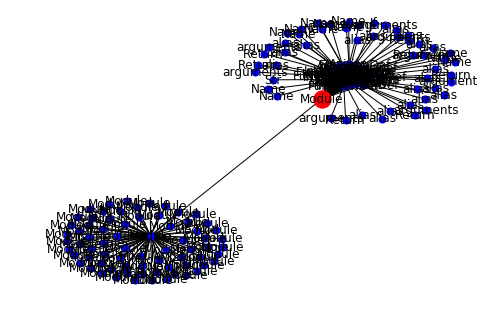

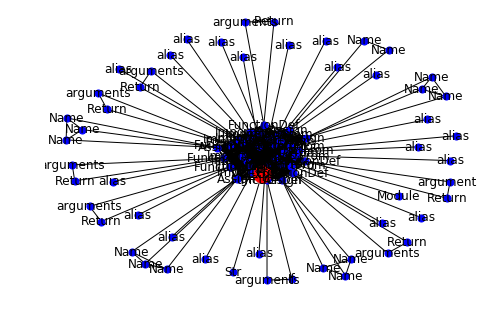

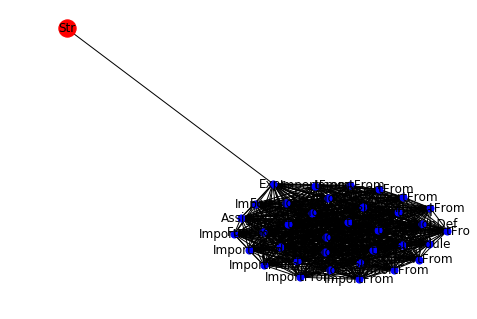

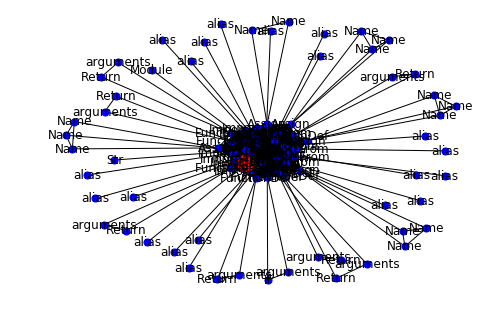

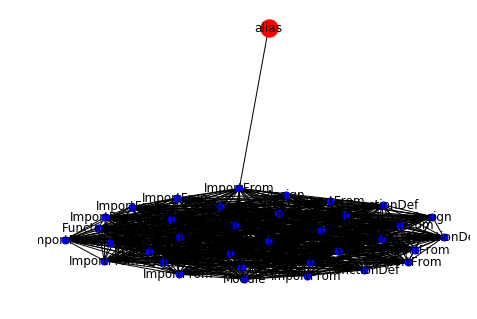

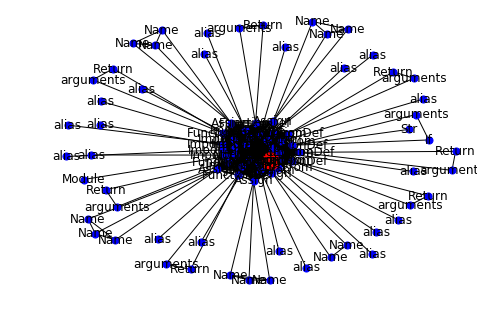

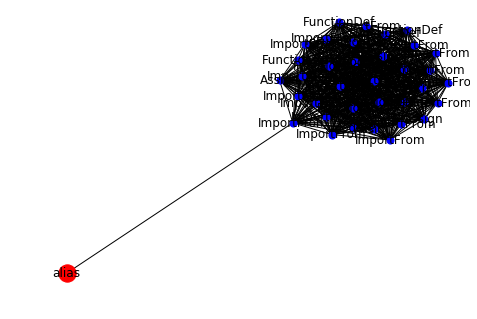

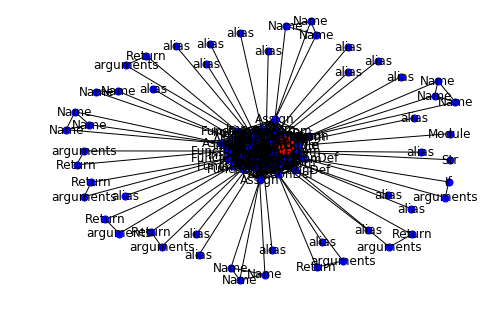

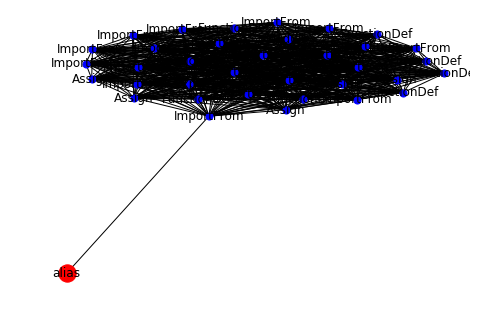

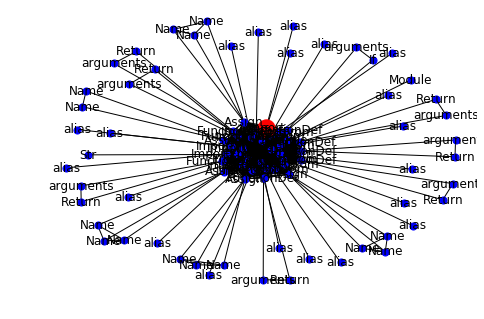

In [172]:
# Example usage 
for i in range(10):
    draw_egonet(i, radius=2)

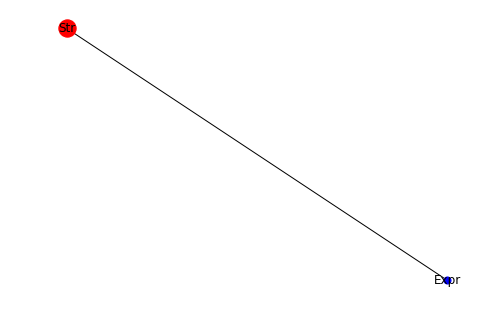

[1, 2]

In [173]:
example_root_node_id = 2
draw_egonet(example_root_node_id, radius=1)

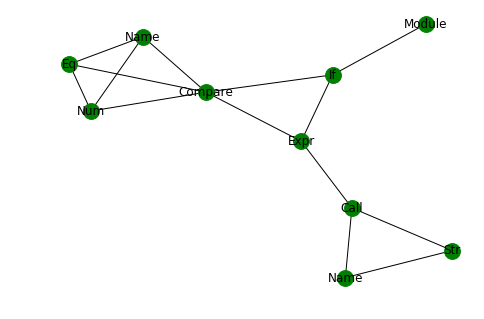

In [152]:
if G.number_of_nodes() < 100:
    labels = {}
    for n in G.nodes():
        labels[n] = get_name_from_token(feats[n], show_id=False)
    pos = nx.layout.kamada_kawai_layout(G)
    nx.draw(G, pos, node_color='g', node_size=250, with_labels=True, labels=labels)

In [ ]:
def get_code_token(node_id):
    top_node, lineno, col_offset = source_map[str(node_id)]
    
    print("node_id =",node_id, "; top_node =",top_node)
    print("token_type =", get_name_from_token(feats[G.nodes()][node_id], show_id=False))


    ast_filename = file_map[str(top_node)]
    source_filename = parse_map[ast_filename]
    
    print()
    
    with open(source_filename[3:]) as f:
        for i, line in enumerate(f):
            if i+1 == lineno:
                print("Line", lineno, ":") 
                print("`", line.strip('\n'),"`")
                if col_offset != -1:
                    l = 0
                    for ls in line.split(): 
                        l += len(ls)
                        if l > col_offset:
                            print("\nToken =",ls)
                            break

In [23]:
get_code_token(1)

node_id = 1 ; top_node = 0
token_type = Expr

Line 2 :
` """ `


---

## Graph analysis

In [149]:
def draw_color_graph(G, measure):
    plt.figure(figsize=(15,15))
    pos = nx.layout.kamada_kawai_layout(G)
    labels = {}
    for n in G.nodes():
        labels[n] = get_name_from_token(feats[n], show_id=False)
    measures = color_list = [v for v in measure(G).values()]
    measure_name = measure.__name__
    
    nodes = nx.draw_networkx_nodes(G, pos, node_size=500, cmap=plt.cm.plasma, 
                                   node_color=measures,
                                   nodelist=G.nodes())
    
    nodes.set_norm(mcolors.SymLogNorm(linthresh=0.01, linscale=1))
    
    # labels = nx.draw_networkx_labels(G, pos)
    edges = nx.draw_networkx_edges(G, pos)
    
    pos_labels = {}
    x_off, y_off = 0.05, 0.05

    for k, v in pos.items():
        pos_labels[k] = (v[0]+x_off, v[1]+y_off)
    
    nx.draw_networkx_labels(G,pos_labels,labels,font_size=16)
    
    plt.title(measure_name)
    plt.colorbar(nodes)
    plt.axis('off')
    plt.show()

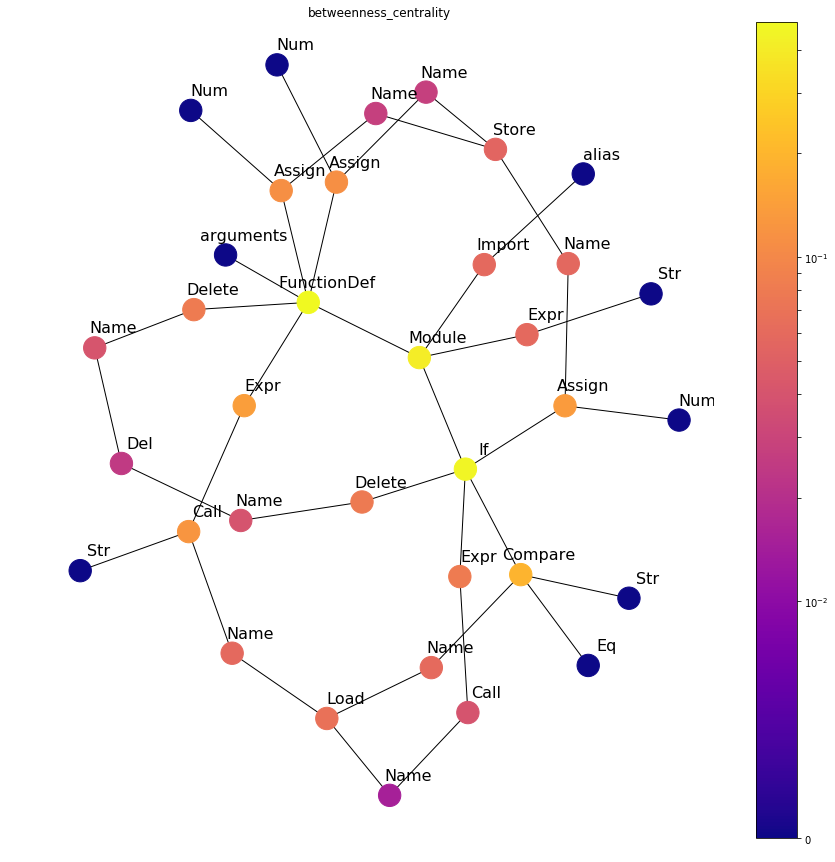

In [150]:
if G.number_of_nodes() < 100:
    draw_color_graph(G, nx.betweenness_centrality)

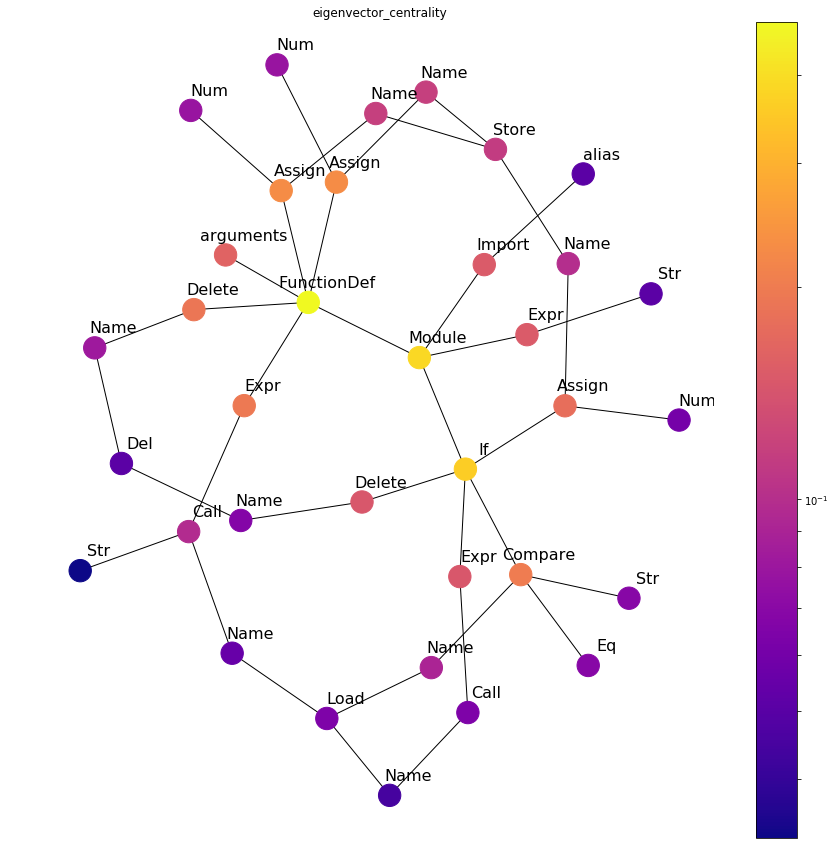

In [151]:
if G.number_of_nodes() < 100:
    draw_color_graph(G, nx.eigenvector_centrality)

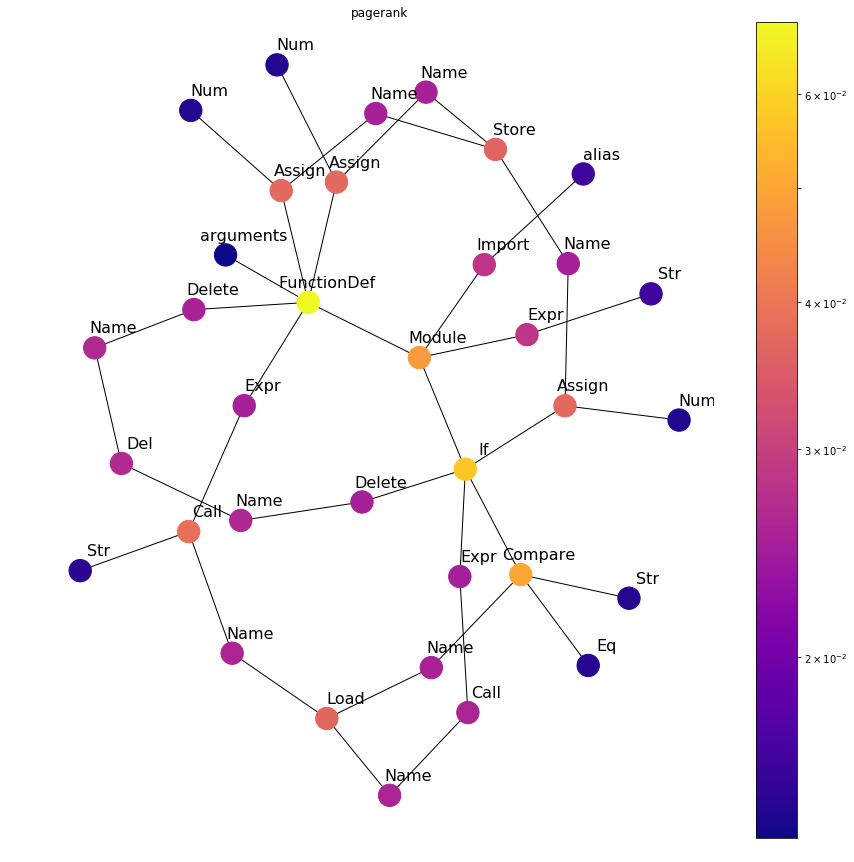

In [152]:
if G.number_of_nodes() < 100:
    draw_color_graph(G, nx.pagerank)

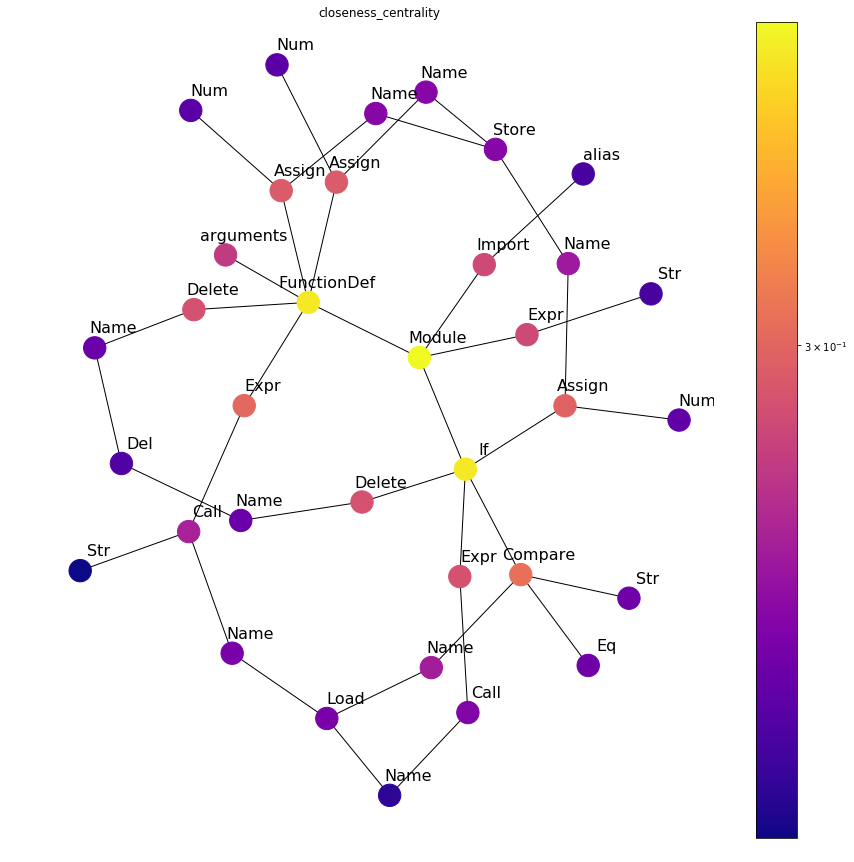

In [153]:
if G.number_of_nodes() < 100:
    draw_color_graph(G, nx.closeness_centrality)

---

## Graph Metrics

### Node degree distribution

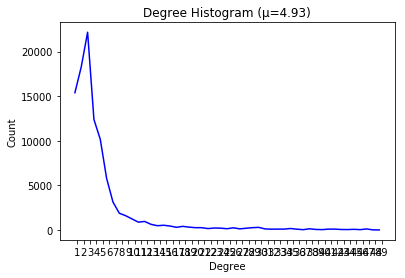

In [174]:
degree_sequence = sorted([d for n, d in G.degree() if d < 50], reverse=True)  # degree sequence
# print "Degree sequence", degree_sequence
degreeCount = collections.Counter(degree_sequence)
deg, cnt = zip(*degreeCount.items())

mean_degree = sum(degree_sequence)/G.number_of_nodes()


fig, ax = plt.subplots()
plt.plot(deg, cnt, color='b')

plt.title("Degree Histogram (µ="+"{:.2f}".format(mean_degree)+")")
plt.ylabel("Count")
plt.xlabel("Degree")
ax.set_xticks([d + 0.4 for d in deg])
ax.set_xticklabels(deg)

plt.show()

In [175]:
degreeCount

Counter({49: 6,
         48: 11,
         47: 114,
         46: 38,
         45: 72,
         44: 47,
         43: 54,
         42: 96,
         41: 94,
         40: 41,
         39: 59,
         38: 133,
         37: 36,
         36: 87,
         35: 163,
         34: 97,
         33: 97,
         32: 90,
         31: 116,
         30: 289,
         29: 259,
         28: 192,
         27: 125,
         26: 243,
         25: 140,
         24: 201,
         23: 220,
         22: 156,
         21: 256,
         20: 258,
         19: 318,
         18: 405,
         17: 300,
         16: 442,
         15: 529,
         14: 477,
         13: 632,
         12: 955,
         11: 878,
         10: 1237,
         9: 1600,
         8: 1876,
         7: 3133,
         6: 5781,
         5: 10160,
         4: 12384,
         3: 22165,
         2: 18288,
         1: 15386})

### Diameter

In [176]:
diams = nx.diameter(G)

KeyboardInterrupt: 

### Eccentricity

In [122]:
ecc_count = collections.Counter(nx.eccentricity(G).values())
deg, cnt = zip(*ecc_count.items())

mean_ecc = sum(nx.eccentricity(G).values())/G.number_of_nodes()

fig, ax = plt.subplots()
plt.bar(deg, cnt, width=0.80, color='b')

plt.title("Eccentricity Histogram (µ="+"{:.2f}".format(mean_ecc)+")")
plt.ylabel("Count")
plt.xlabel("Eccentricity")
ax.set_xticks([d + 0.4 for d in deg])
ax.set_xticklabels(deg)

plt.show()

KeyboardInterrupt: 

## Graph subsampling

In [177]:
G_filt = nx.Graph()
G_filt.add_nodes_from([n for n, d in G.degree() if d < 50])

In [178]:
G_filt.add_edges_from([edge for edge in G.edges if ((edge[0] in G_filt.nodes) and (edge[1] in G_filt.nodes))])

In [179]:
G_filt.number_of_nodes(), G_filt.number_of_edges()

(100736, 243786)

In [180]:
G.number_of_nodes(), G.number_of_edges()

(101632, 317327)

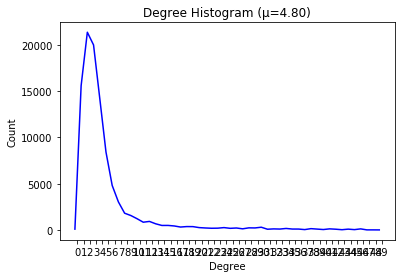

In [181]:
degree_sequence = sorted([d for n, d in G_filt.degree()], reverse=True)  # degree sequence
# print "Degree sequence", degree_sequence
degreeCount = collections.Counter(degree_sequence)
deg, cnt = zip(*degreeCount.items())

mean_degree = sum(degree_sequence)/G.number_of_nodes()


fig, ax = plt.subplots()
plt.plot(deg, cnt, color='b')

plt.title("Degree Histogram (µ="+"{:.2f}".format(mean_degree)+")")
plt.ylabel("Count")
plt.xlabel("Degree")
ax.set_xticks([d + 0.4 for d in deg])
ax.set_xticklabels(deg)

plt.show()

## Feature distribution

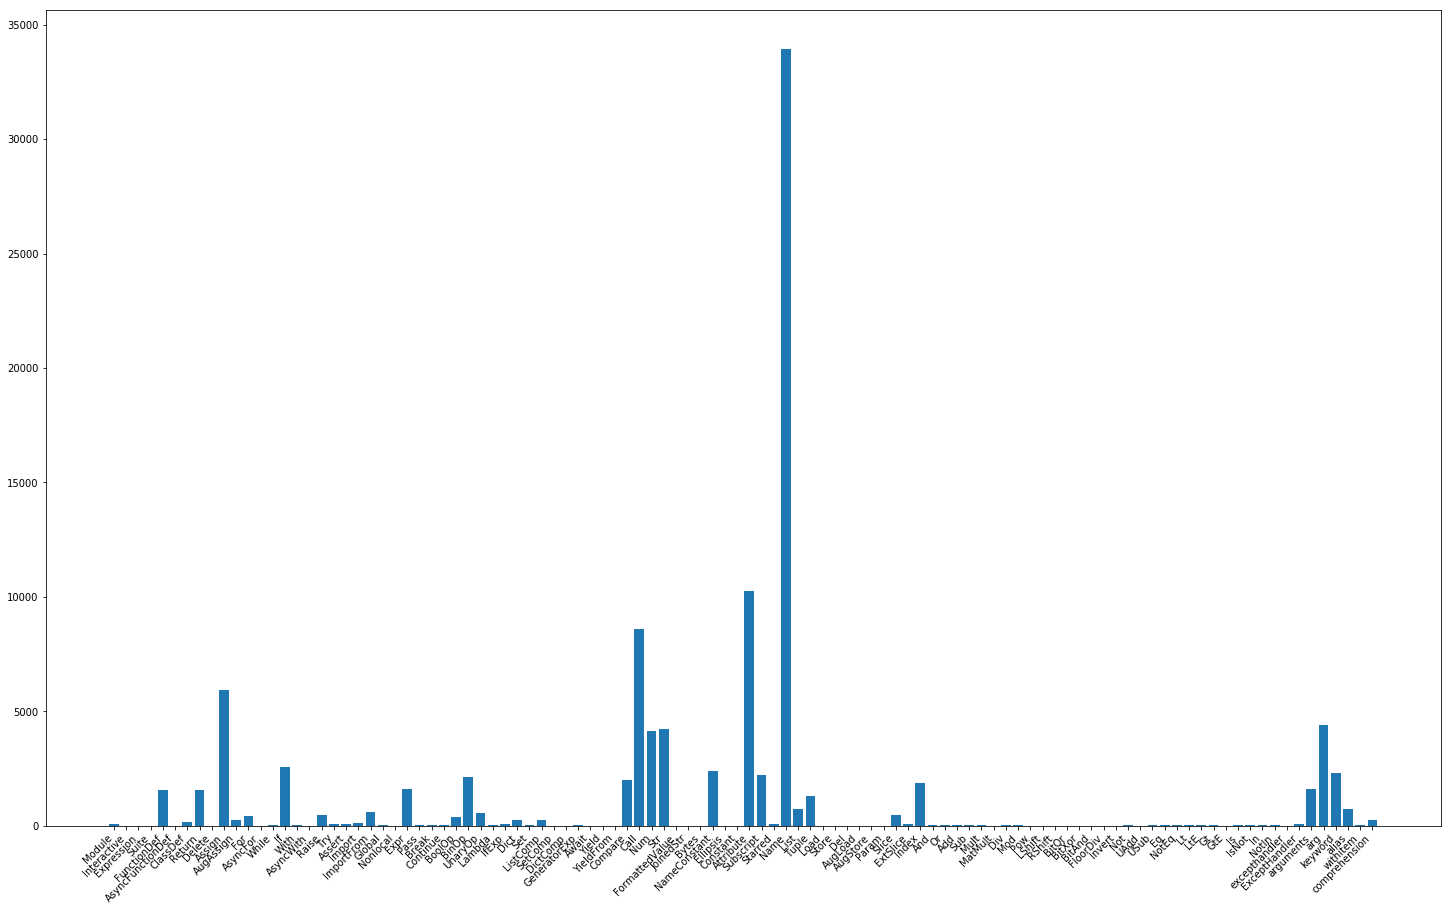

In [128]:
plt.figure(figsize=(25,15))
plt.bar(range(104),feats.sum(axis=0));
plt.xticks(range(104),[_.__name__ for _ in PYTHON_SYMBOLS],rotation=45, ha="right");

In [129]:
from collections import Counter

classes = [0]*14
for k,v in class_map.items():
    classes[v] += class_map[k]

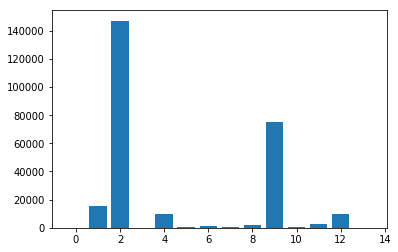

In [130]:
plt.bar(range(14),classes);

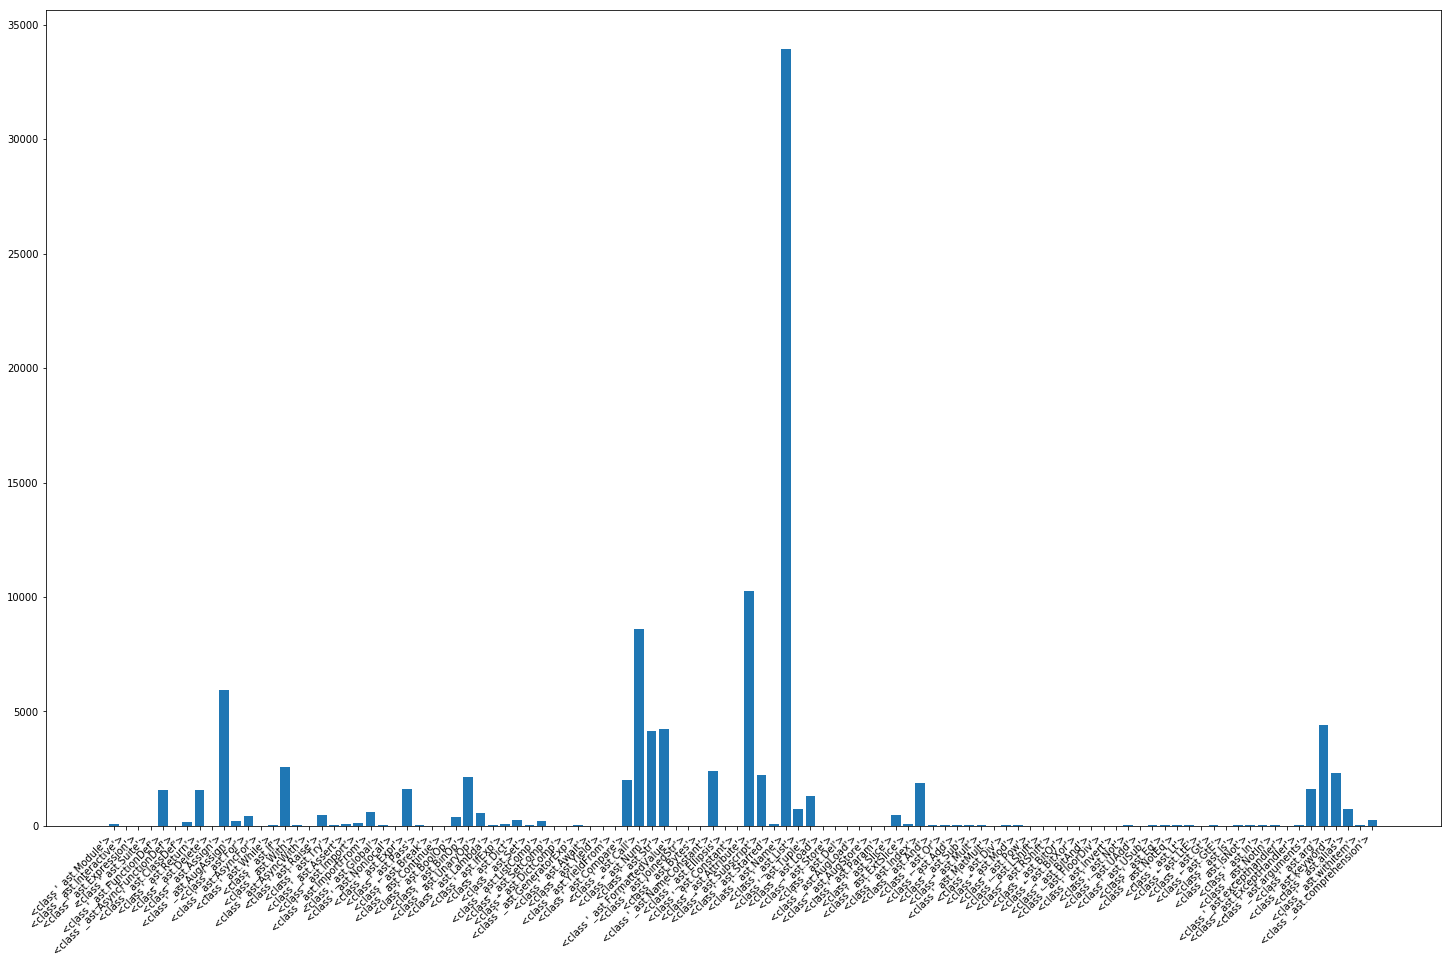

In [131]:
plt.figure(figsize=(25,15))
plt.bar(range(104),feats.sum(axis=0));
plt.xticks(range(104),PYTHON_SYMBOLS,rotation=45, ha="right");